In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from sklearn.preprocessing import MinMaxScaler
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

import torch
import torch.nn as nn

In [2]:
path='./drive/MyDrive/Colab Notebooks/Data/netflix-stock-prediction'
train_data=pd.read_csv(path+'/train.csv')
test_data=pd.read_csv(path+'/test.csv')
submission=pd.read_csv(path+'/sample_submission.csv')

In [3]:
train_data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [40]:
test_data.head()

,Date,Open,High,Low,Volume
0,2019-10-21,273,280,269,12599200
1,2019-10-22,271,275,266,11802400
2,2019-10-23,268,274,267,7133500
3,2019-10-24,272,274,269,4827400
4,2019-10-25,271,278,270,4747800


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


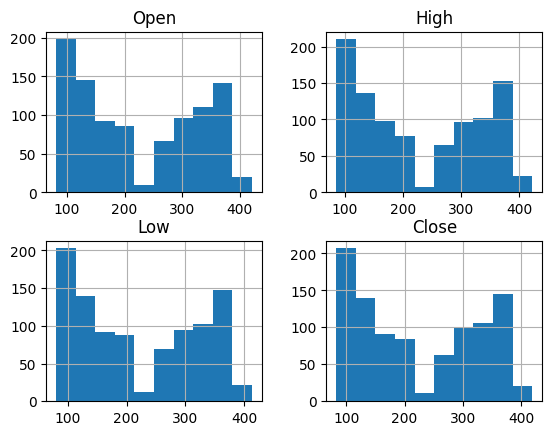

In [5]:
data_used=train_data.iloc[:,1:4]
data_used['Close']=train_data['Close']
hist=data_used.hist()
plt.show()

In [60]:
class Netflix(Dataset):
  def __init__(self,train):
    self.csv=train

    #Normalization
    self.scaler=MinMaxScaler()
    self.data=self.csv.iloc[:,1:4].values
    self.data=self.scaler.fit_transform(self.data)

    self.label=self.csv['Close'].values.reshape(-1,1)
    self.label=self.scaler.fit_transform(self.label)
    self.label=self.label.ravel()

  def __len__(self):
    return len(self.data) - 30

  def __getitem__(self,idx):
    #batch_size=30, reading data in 30-day chunks
    data=self.data[idx:idx+30]
    label=self.label[idx+30]
    return data, label

In [56]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN,self).__init__()

    self.rnn=nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
    self.fc1=nn.Linear(in_features=240, out_features=64)
    self.fc2=nn.Linear(in_features=64, out_features=1)

    self.relu=nn.ReLU()

  def forward(self,x,h0):
    x,hn = self.rnn(x,h0)

    x=torch.reshape(x, (x.shape[0],-1))

    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)

    x=torch.flatten(x)

    return x


In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model=RNN().to(device)
dataset=Netflix(train_data)

loader=DataLoader(dataset,batch_size=32)
optim=Adam(model.parameters(),lr=1e-4)

for epoch in range(200):
  iter=tqdm.tqdm(loader)
  for data, label in iter:
    optim.zero_grad()

    h0=torch.zeros(5,data.shape[0],8).to(device)

    pred=model(data.type(torch.FloatTensor).to(device),h0)

    loss=nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()

    iter.set_description(f'epoch:{epoch+1} loss: {loss.item()}')

torch.save(model.state_dict(),'./drive/MyDrive/Colab Notebooks/Model_weight/RNN_Netflix.pth')

epoch:200 loss: 0.000537462008651346: 100%|██████████| 30/30 [00:00<00:00, 129.62it/s]


In [62]:
dataset=Netflix(train_data)

loader=DataLoader(dataset,batch_size=1)

preds=[]
total_loss=0

model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/Model_weight/RNN_Netflix.pth',map_location=device))
with torch.no_grad():
  for data,label in loader:
    h0=torch.zeros(5,data.shape[0],8).to(device)
    pred=model(data.type(torch.FloatTensor).to(device),h0)
    preds.append(pred.item())

    loss=nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    total_loss+=loss.item()/len(loader)

print(total_loss)

<ipython-input-62-de41a4bf297e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/Model_weight/RNN_Netflix.p

0.0014343078666213549


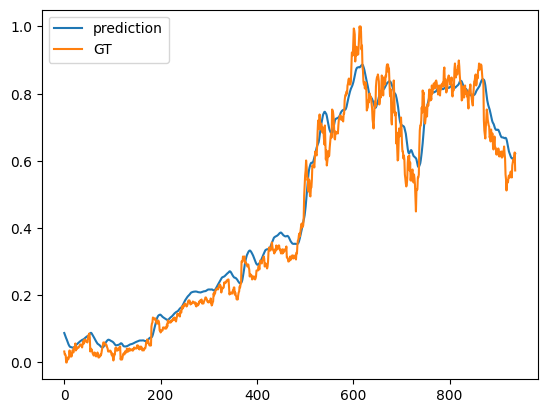

In [54]:
plt.plot(preds,label='prediction')
plt.plot(dataset.label[30:],label='GT')
plt.legend()
plt.show()